# Human Connectome Project (HCP) Dataset loader

The HCP dataset comprises resting-state and task-based fMRI from a large sample of human subjects. The NMA-curated dataset includes time series data that has been preprocessed and spatially-downsampled by aggregating within 360 regions of interest.

In [2]:
# @title Install dependencies
!pip install nilearn seaborn --quiet

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Necessary for visualization
from nilearn import plotting, datasets

# SDL model
from sklearn.linear_model import orthogonal_mp_gram

from tqdm import tqdm

In [4]:
#@title Figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

# Basic parameters

In [5]:
# The download cells will store the data in nested directories starting here:
HCP_DIR = "./DATA"
if not os.path.isdir(HCP_DIR):
  os.mkdir(HCP_DIR)

# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 339

# The data have already been aggregated into ROIs from the Glasesr parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in sec

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated multiple times in each subject
N_RUNS_REST = 4
N_RUNS_TASK = 2

# Time series data are organized by experiment, with each experiment
# having an LR and RL (phase-encode direction) acquistion
BOLD_NAMES = [
  "rfMRI_REST1_LR", "rfMRI_REST1_RL",
  "rfMRI_REST2_LR", "rfMRI_REST2_RL",
  "tfMRI_MOTOR_RL", "tfMRI_MOTOR_LR",
  "tfMRI_WM_RL", "tfMRI_WM_LR",
  "tfMRI_EMOTION_RL", "tfMRI_EMOTION_LR",
  "tfMRI_GAMBLING_RL", "tfMRI_GAMBLING_LR",
  "tfMRI_LANGUAGE_RL", "tfMRI_LANGUAGE_LR",
  "tfMRI_RELATIONAL_RL", "tfMRI_RELATIONAL_LR",
  "tfMRI_SOCIAL_RL", "tfMRI_SOCIAL_LR"
]

# You may want to limit the subjects used during code development.
# This will use all subjects:
subjects = range(N_SUBJECTS)

# Downloading data

The rest and task data are shared in different files, but they will unpack into the same directory structure.

Each file is fairly large and will take some time to download. If you are focusing only on rest or task analyses, you may not want to download only that dataset.

We also separately provide some potentially useful behavioral covariate information.

In [6]:
# @title Download the data

# @markdown Task data in `HCP_DIR/hcp_task`, rest in `HCP_DIR/hcp_rest`, covariate in `HCP_DIR/hcp`

import os, requests, tarfile

fnames = ["hcp_rest.tgz",
          "hcp_task.tgz",
          "hcp_covariates.tgz",
          "atlas.npz"]
urls = ["https://osf.io/bqp7m/download",
        "https://osf.io/s4h8j/download",
        "https://osf.io/x5p4g/download",
        "https://osf.io/j5kuc/download"]

for fname, url in zip(fnames, urls):
  if not os.path.isfile(fname):
    try:
      r = requests.get(url)
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        print(f"Downloading {fname}...")
        with open(fname, "wb") as fid:
          fid.write(r.content)
        print(f"Download {fname} completed!")

In [7]:
# @title Extract the data in `HCP_DIR`
fnames = ["hcp_covariates", "hcp_rest", "hcp_task"]

for fname in fnames:
  # open file
  path_name = os.path.join(HCP_DIR, fname)
  if not os.path.exists(path_name):
    print(f"Extracting {fname}.tgz...")
    with tarfile.open(f"{fname}.tgz") as fzip:
      fzip.extractall(HCP_DIR)
  else:
    print(f"File {fname}.tgz has already been extracted.")

Extracting hcp_covariates.tgz...
File hcp_rest.tgz has already been extracted.
File hcp_task.tgz has already been extracted.


## Loading region information

Downloading either dataset will create the `regions.npy` file, which contains the region name and network assignment for each parcel.

Detailed information about the name used for each region is provided [in the Supplement](https://static-content.springer.com/esm/art%3A10.1038%2Fnature18933/MediaObjects/41586_2016_BFnature18933_MOESM330_ESM.pdf) to [Glasser et al. 2016](https://www.nature.com/articles/nature18933).

Information about the network parcellation is provided in [Ji et al, 2019](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6289683/).

In [8]:
dir = os.path.join(HCP_DIR, "hcp_task")  # choose the data directory
regions = np.load(os.path.join(dir, "regions.npy")).T
region_info = dict(name=regions[0].tolist(),
                   network=regions[1],
                   myelin=regions[2].astype(float)
                   )

We also provide the [parcellation on the fsaverage5 surface](https://figshare.com/articles/HCP-MMP1_0_projected_on_fsaverage/3498446) and approximate MNI coordinates of each region, which can be useful for visualization:

In [9]:
with np.load(f"atlas.npz") as dobj:
  atlas = dict(**dobj)

# Helper functions


## Data loading

In [10]:
def get_image_ids(name):
  """Get the 1-based image indices for runs in a given experiment.

    Args:
      name (str) : Name of experiment ("rest" or name of task) to load
    Returns:
      run_ids (list of int) : Numeric ID for experiment image files

  """
  run_ids = [
             i for i, code in enumerate(BOLD_NAMES, 1) if name.upper() in code
             ]
  if not run_ids:
    raise ValueError(f"Found no data for '{name}'")
  return run_ids


def load_timeseries(subject, name, dir,
                    runs=None, concat=True, remove_mean=True):
  """Load timeseries data for a single subject.

  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of experiment ("rest" or name of task) to load
    dir (str) : data directory
    run (None or int or list of ints): 0-based run(s) of the task to load,
      or None to load all runs.
    concat (bool) : If True, concatenate multiple runs in time
    remove_mean (bool) : If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_tp array): Array of BOLD data values

  """
  # Get the list relative 0-based index of runs to use
  if runs is None:
    runs = range(N_RUNS_REST) if name == "rest" else range(N_RUNS_TASK)
  elif isinstance(runs, int):
    runs = [runs]

  # Get the first (1-based) run id for this experiment
  offset = get_image_ids(name)[0]

  # Load each run's data
  bold_data = [
               load_single_timeseries(subject,
                                      offset + run,
                                      dir,
                                      remove_mean) for run in runs
               ]

  # Optionally concatenate in time
  if concat:
    bold_data = np.concatenate(bold_data, axis=-1)

  return bold_data


def load_single_timeseries(subject, bold_run, dir, remove_mean=True):
  """Load timeseries data for a single subject and single run.

  Args:
    subject (int): 0-based subject ID to load
    bold_run (int): 1-based run index, across all tasks
    dir (str) : data directory
    remove_mean (bool): If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_path = os.path.join(dir, "subjects", str(subject), "timeseries")
  bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"
  ts = np.load(os.path.join(bold_path, bold_file))
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts


def load_evs(subject, name, condition, dir):
  """Load EV (explanatory variable) data for one task condition.

  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of task
    condition (str) : Name of condition
    dir (str) : data directory

  Returns
    evs (list of dicts): A dictionary with the onset, duration, and amplitude
      of the condition for each run.

  """
  evs = []
  for id in get_image_ids(name):
    task_key = BOLD_NAMES[id - 1]
    ev_file = os.path.join(dir, "subjects", str(subject), "EVs",
                           task_key, f"{condition}.txt")
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev = dict(zip(["onset", "duration", "amplitude"], ev_array))
    evs.append(ev)
  return evs

## Task-based analysis

In [11]:
def condition_frames(run_evs, skip=0):
  """Identify timepoints corresponding to a given condition in each run.

  Args:
    run_evs (list of dicts) : Onset and duration of the event, per run
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    frames_list (list of 1D arrays): Flat arrays of frame indices, per run

  """
  frames_list = []
  for ev in run_evs:

    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)

    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)

    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(skip, d) for s, d in zip(start, duration)]

    frames_list.append(np.concatenate(frames))

  return frames_list


def selective_average(timeseries_data, ev, skip=0):
  """Take the temporal mean across frames for a given condition.

  Args:
    timeseries_data (array or list of arrays): n_parcel x n_tp arrays
    ev (dict or list of dicts): Condition timing information
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    avg_data (1D array): Data averagted across selected image frames based
    on condition timing

  """
  # Ensure that we have lists of the same length
  if not isinstance(timeseries_data, list):
    timeseries_data = [timeseries_data]
  if not isinstance(ev, list):
    ev = [ev]
  if len(timeseries_data) != len(ev):
    raise ValueError("Length of `timeseries_data` and `ev` must match.")

  # Identify the indices of relevant frames
  frames = condition_frames(ev, skip)

  # Select the frames from each image
  selected_data = []
  for run_data, run_frames in zip(timeseries_data, frames):
    run_frames = run_frames[run_frames < run_data.shape[1]]
    selected_data.append(run_data[:, run_frames])

  # Take the average in each parcel
  avg_data = np.concatenate(selected_data, axis=-1).mean(axis=-1)

  return avg_data

# Resting-state analyses

Load a single run of resting-state data:

In [12]:
help(load_timeseries)

Help on function load_timeseries in module __main__:

load_timeseries(subject, name, dir, runs=None, concat=True, remove_mean=True)
    Load timeseries data for a single subject.
    
    Args:
      subject (int): 0-based subject ID to load
      name (str) : Name of experiment ("rest" or name of task) to load
      dir (str) : data directory
      run (None or int or list of ints): 0-based run(s) of the task to load,
        or None to load all runs.
      concat (bool) : If True, concatenate multiple runs in time
      remove_mean (bool) : If True, subtract the parcel-wise mean
    
    Returns
      ts (n_parcel x n_tp array): Array of BOLD data values



In [13]:
timeseries = load_timeseries(subject=0,
                             name="rest",
                             dir=os.path.join(HCP_DIR, "hcp_rest"),
                             runs=1)
print(timeseries.shape)  # n_parcel x n_timepoint

(360, 1200)


Load a concatenated resting-state timeseries (using all runs' data) for each subject:

In [14]:
timeseries_rest = []
for subject in subjects:
  ts_concat = load_timeseries(subject, name="rest",
                              dir=os.path.join(HCP_DIR, "hcp_rest"))
  timeseries_rest.append(ts_concat)

In [15]:
timeseries_task = []
for subject in subjects:
  timeseries_task.append(load_timeseries(subject, "motor",
                                         dir=os.path.join(HCP_DIR, "hcp_task"),
                                         concat=False))

In [16]:
timeseries_task = np.array(timeseries_task)
print(timeseries_task.shape)

(339, 2, 360, 284)


## Run a simple correlation-based "functional connectivity" analysis

Generate a correlation matrix (showing "functional connectivity" or FC) for each subject and plot the group average:

In [17]:
# Plot subject wise fc
fc = np.zeros((N_SUBJECTS, N_PARCELS, N_PARCELS))
for sub, ts in enumerate(timeseries_rest):
  fc[sub] = np.corrcoef(ts)

In [18]:
fc_lf = np.zeros((N_SUBJECTS, N_PARCELS, N_PARCELS))
for sub, ts in enumerate(timeseries_task[:, 0, :, :]):
  fc_lf[sub] = np.corrcoef(ts)

In [19]:
# correlation mat betwwen fc and fc_lf
import seaborn as sns
corr = np.corrcoef(fc.reshape(N_SUBJECTS, -1), fc_lf.reshape(N_SUBJECTS, -1))[:339, 339:]
print(corr.shape)

(339, 339)


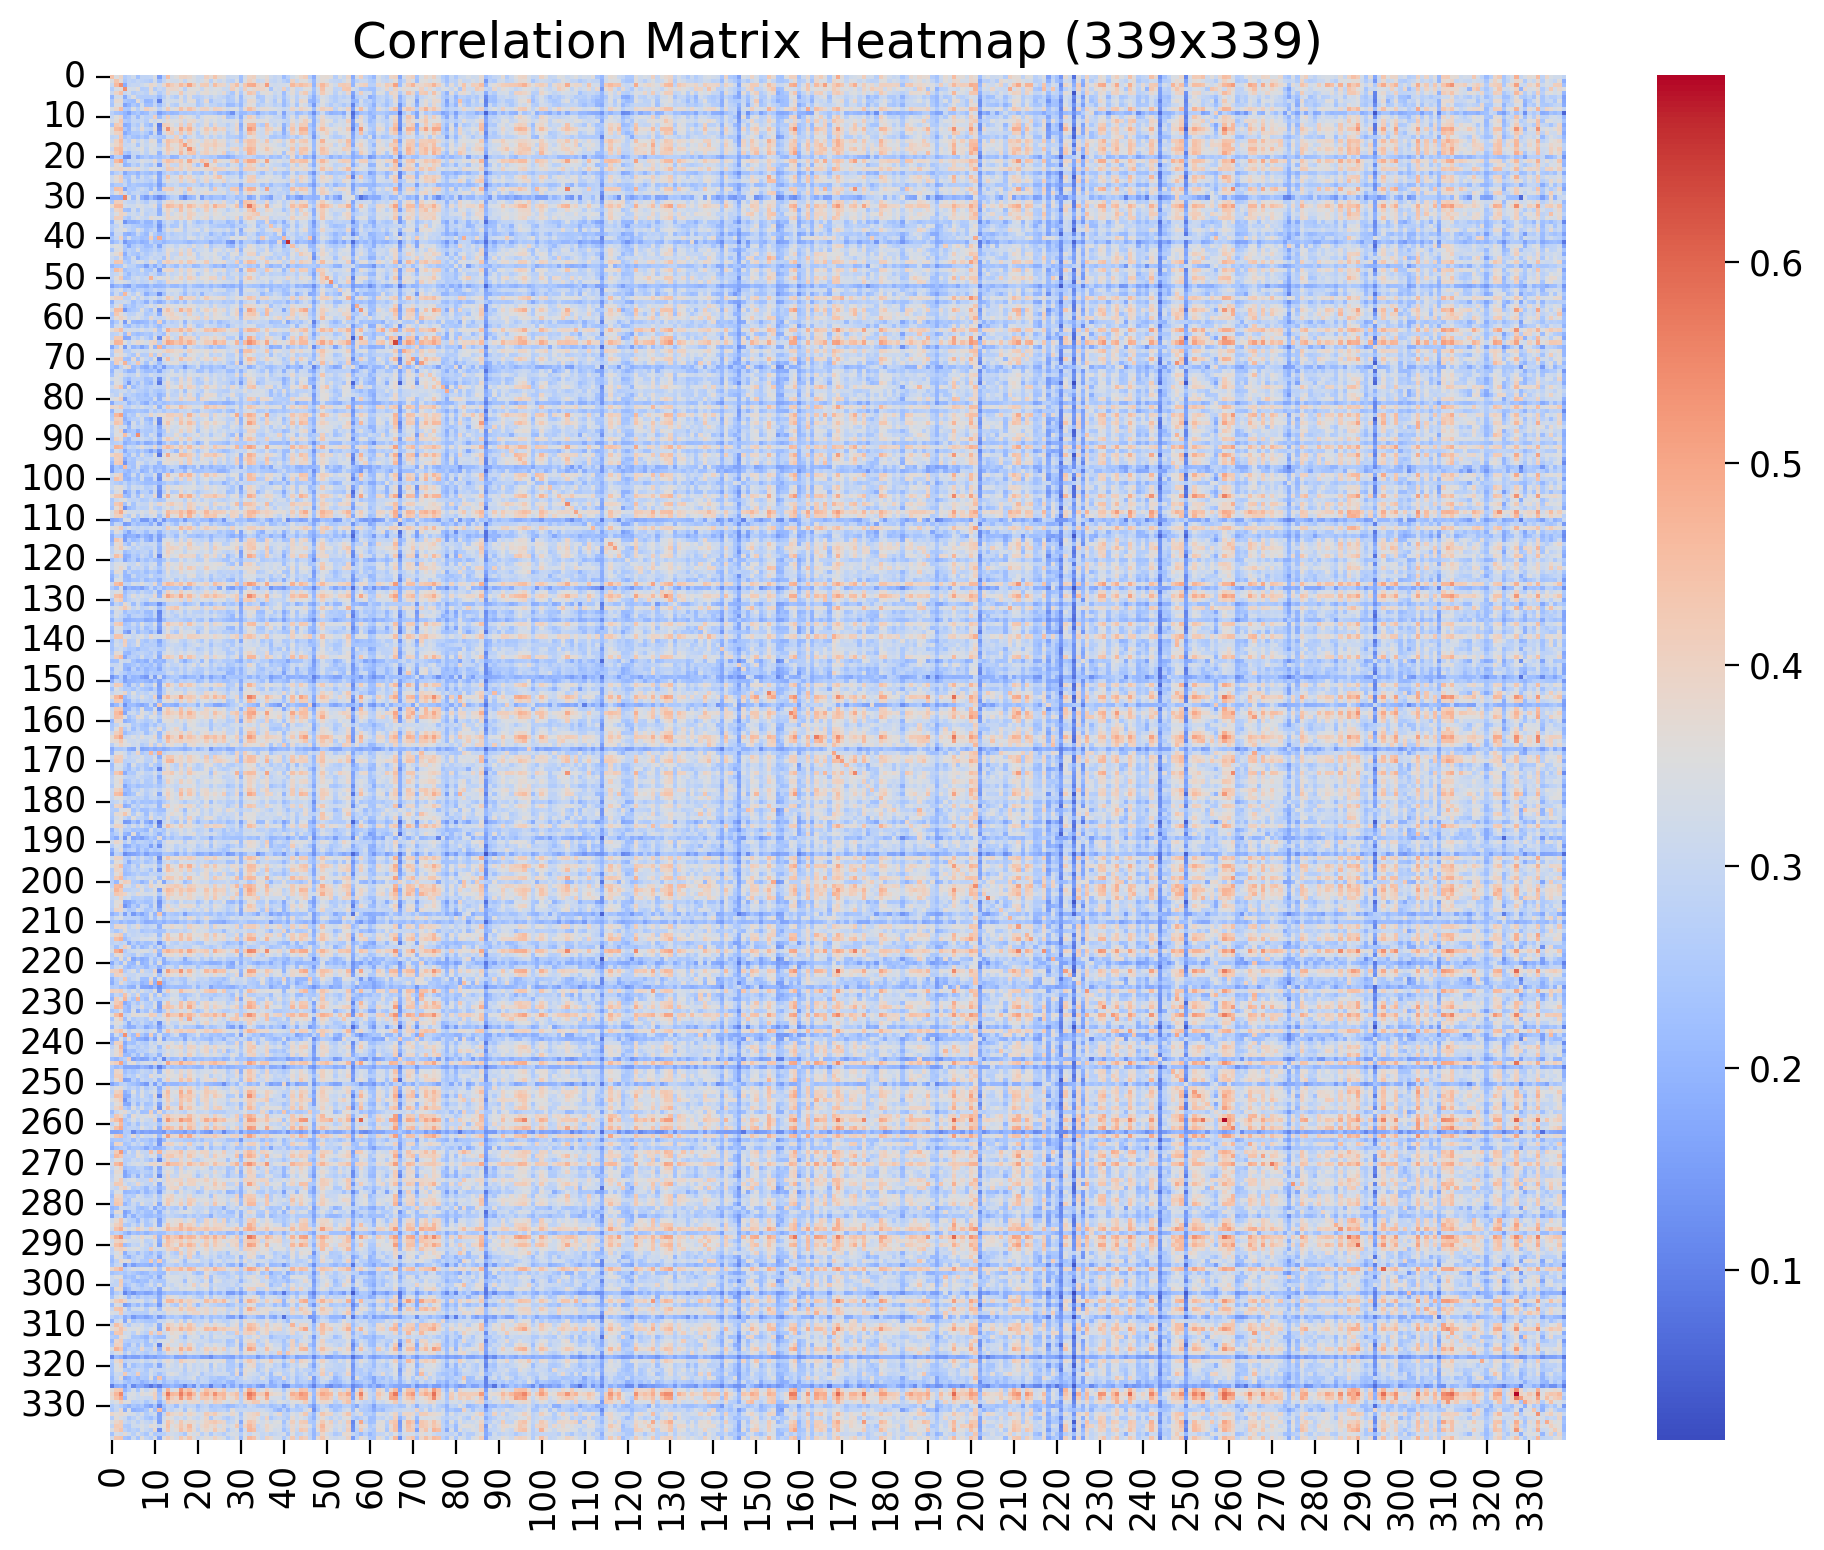

In [20]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=False, cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix Heatmap (339x339)")
plt.show()

In [21]:
def calculate_accuracy(correlation_matrix):
    num_correct = 0
    num_items = correlation_matrix.shape[0]
    
    for i in range(num_items):
        if correlation_matrix[i, i] == np.max(correlation_matrix[i, :]):
            num_correct += 1
            
    accuracy = num_correct / num_items
    return accuracy

print(calculate_accuracy(corr))

0.23893805309734514


Epoch [1/20], Loss: 0.1657
Epoch [2/20], Loss: 0.0560
Epoch [3/20], Loss: 0.0393
Epoch [4/20], Loss: 0.0351
Epoch [5/20], Loss: 0.0332
Epoch [6/20], Loss: 0.0338
Epoch [7/20], Loss: 0.0326
Epoch [8/20], Loss: 0.0318
Epoch [9/20], Loss: 0.0308
Epoch [10/20], Loss: 0.0302
Epoch [11/20], Loss: 0.0299
Epoch [12/20], Loss: 0.0295
Epoch [13/20], Loss: 0.0288
Epoch [14/20], Loss: 0.0289
Epoch [15/20], Loss: 0.0283
Epoch [16/20], Loss: 0.0281
Epoch [17/20], Loss: 0.0278
Epoch [18/20], Loss: 0.0275
Epoch [19/20], Loss: 0.0273
Epoch [20/20], Loss: 0.0270
Training complete


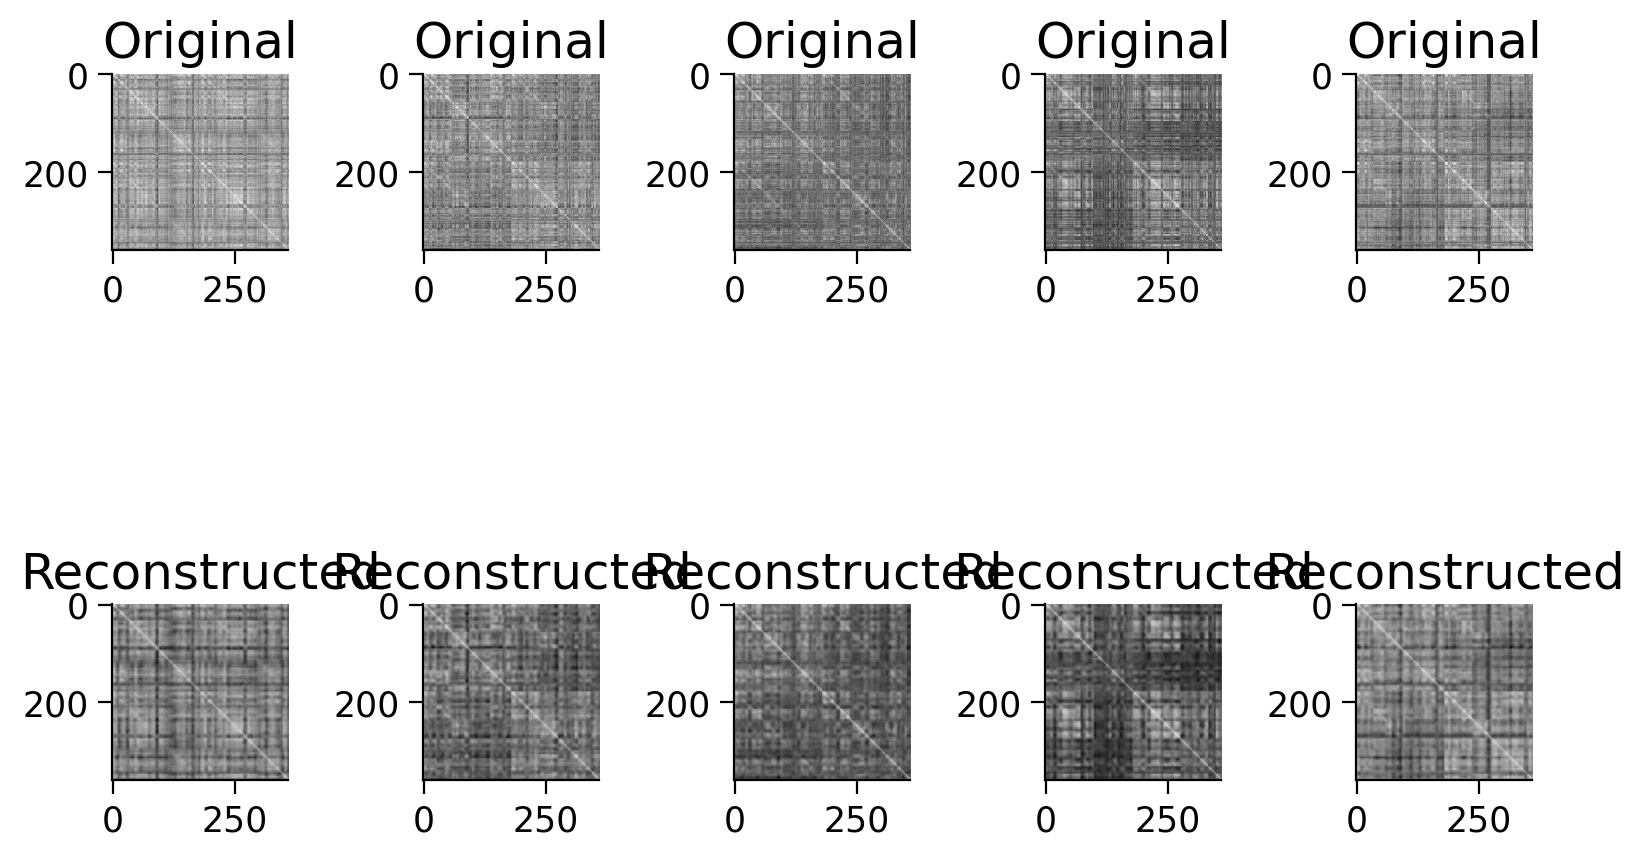

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

data = fc

# Reshape data to (339, 1, 360, 360) to add a channel dimension
data = data[:, np.newaxis, :, :]

# Convert the data to PyTorch tensors
data_tensor = torch.tensor(data, dtype = torch.float32)

# Create a DataLoader for batch processing
dataset = TensorDataset(data_tensor, data_tensor)  # Use data as both input and target
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Define the convolutional autoencoder
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),  # (batch_size, 16, 360, 360)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # (batch_size, 16, 180, 180)
            nn.Conv2d(16, 32, kernel_size=3, padding=1),  # (batch_size, 32, 180, 180)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # (batch_size, 32, 90, 90)
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # (batch_size, 64, 90, 90)
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # (batch_size, 64, 45, 45)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),  # (batch_size, 32, 90, 90)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),  # (batch_size, 16, 180, 180)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=2, stride=2),   # (batch_size, 1, 360, 360)
            nn.Tanh()  # To bring output between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize the model, loss function, and optimizer
model = ConvAutoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20

for epoch in range(num_epochs):
    running_loss = 0.0
    for data in dataloader:
        inputs, _ = data

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, inputs)  # Compare reconstructed output with the input

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item()

    # Print average loss for each epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}')

print('Training complete')

# Visualize a few reconstructed examples
def visualize_reconstruction(model, data_tensor):
    model.eval()
    with torch.no_grad():
        sample = data_tensor[:5]  # Take 5 samples
        reconstructed = model(sample)

        # Plot original and reconstructed images side by side
        for i in range(5):
            plt.subplot(2, 5, i+1)
            plt.imshow(sample[i].squeeze(0).numpy(), cmap='gray')
            plt.title("Original")

            plt.subplot(2, 5, i+6)
            plt.imshow(reconstructed[i].squeeze(0).numpy(), cmap='gray')
            plt.title("Reconstructed")

        plt.show()

# Visualize the reconstruction of the first 5 samples
visualize_reconstruction(model, data_tensor)


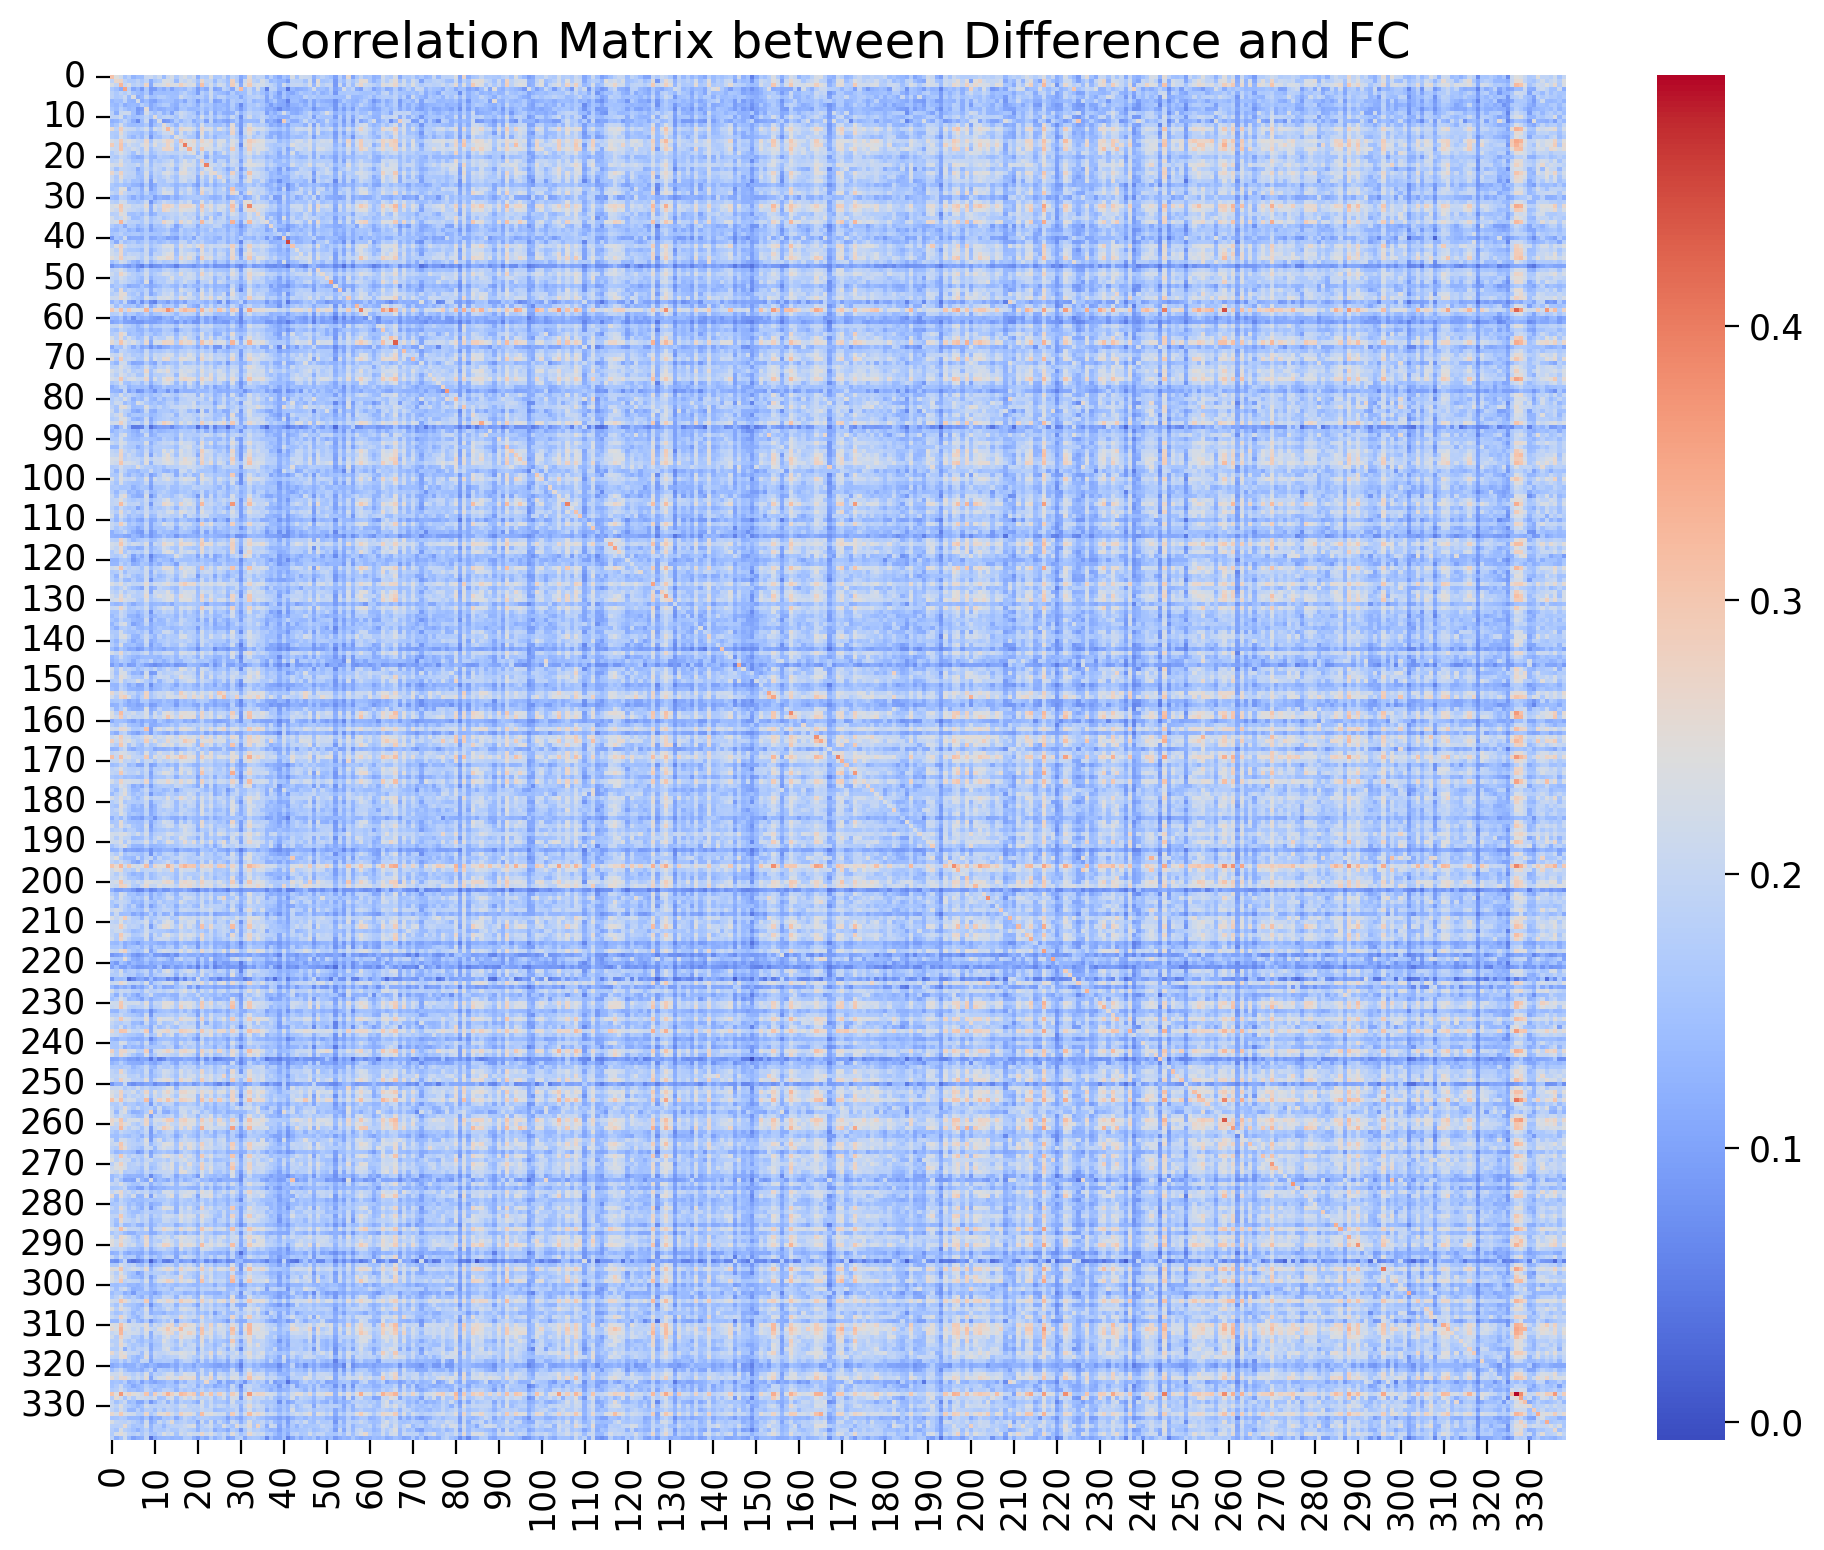

In [23]:
fc_left_tensor = torch.tensor(fc_lf[:, np.newaxis, :, :], dtype = torch.float32)
fc_tensor = torch.tensor(fc[:, np.newaxis, :, :])

# Create a DataLoader for fc_left
dataset = TensorDataset(fc_left_tensor, fc_left_tensor)  # Use fc_left as both input and target
dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

model.eval()  # Set model to evaluation mode

with torch.no_grad():
    reconstructed_list = []
    for data in dataloader:
        inputs, _ = data
        outputs = model(inputs)  # Reconstructed fc_left
        reconstructed_list.append(outputs)

# Concatenate the reconstructed batches
reconstructed_fc_left = torch.cat(reconstructed_list)

# Subtract original fc_left from reconstructed_fc_left to get the difference
difference = fc_left_tensor - reconstructed_fc_left

# Reshape difference and fc to (339, 360*360) for correlation calculation
difference_flat = difference.view(339, -1)  # Shape: (339, 360*360)
fc_flat = fc_tensor.view(339, -1)           # Shape: (339, 360*360)

# Calculate correlation matrix between flattened difference and fc
difference_flat_np = difference_flat.numpy()
fc_flat_np = fc_flat.numpy()

# Compute the correlation matrix
correlation_matrix = np.corrcoef(difference_flat_np, fc_flat_np, rowvar=True)

# Extract the relevant part of the correlation matrix (339x339)
correlation_matrix = correlation_matrix[:339, 339:]

# Plotting the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix between Difference and FC")
plt.show()

In [24]:
print(calculate_accuracy(correlation_matrix))

0.3746312684365782


In [25]:
import numpy as np
from sklearn.linear_model import orthogonal_mp
from numpy.linalg import svd
from tqdm import tqdm 

# K-SVD Algorithm

def omp_sparse_coding(Y, D, L):
    """ Solves for X using Orthogonal Matching Pursuit (OMP) algorithm """
    n = Y.shape[1]
    X = np.zeros((D.shape[1], n))
    
    for i in range(n):
        # Solve for each subject (Y[:,i]) and get the sparse representation
        X[:, i] = orthogonal_mp(D, Y[:, i], n_nonzero_coefs=L)
        
    return X

def update_dictionary(Y, D, X):
    """ Updates the dictionary D using SVD on the residual """
    for k in range(D.shape[1]):
        # Find the indices where X has non-zero entries for the current atom k
        non_zero_indices = np.nonzero(X[k, :])[0]
        
        if len(non_zero_indices) == 0:
            continue
        
        # Compute the residual without using the k-th atom
        residual = Y[:, non_zero_indices] - np.dot(D, X[:, non_zero_indices])
        residual += np.outer(D[:, k], X[k, non_zero_indices])
        
        # Apply SVD to the residual to find new dk and xk
        U, S, Vt = svd(residual, full_matrices=False)
        D[:, k] = U[:, 0]
        X[k, non_zero_indices] = S[0] * Vt[0, :]
        
    return D, X

def k_svd(Y, K, L, n_iter=10):
    """ K-SVD algorithm for sparse dictionary learning """
    m, n = Y.shape
    
    # Initialize the dictionary with random values
    D = np.random.randn(m, K)
    D = D / np.linalg.norm(D, axis=0)  # Normalize columns of D
    
    with tqdm(total=n_iter) as pbar:
        for iteration in range(n_iter):
            # Step 1: Sparse coding (OMP)
            X = omp_sparse_coding(Y, D, L)

            # Step 2: Dictionary update (SVD)
            D, X = update_dictionary(Y, D, X)

            # Calculate the reconstruction error
            reconstruction_error = np.linalg.norm(Y - np.dot(D, X), 'fro')

            # Update the progress bar with reconstruction error
            pbar.set_description(f"Iteration {iteration + 1}/{n_iter}, Reconstruction Error: {reconstruction_error:.6f}")
            pbar.update(1)
    
    return D, X

# D: Learned dictionary (m x K)
# X: Sparse representation matrix (K x n)

In [26]:
def extract_upper_triangular(correlation_matrices):
    num_matrices = correlation_matrices.shape[0]
    
    # Use np.triu_indices to get the indices of the upper triangular part without the diagonal
    upper_tri_indices = np.triu_indices(360, k=1)  # k=1 excludes the diagonal

    # Initialize a list to store the upper triangular values from each matrix
    upper_triangular_values = []

    for i in range(num_matrices):
        # Extract the upper triangular part (excluding diagonal) for the i-th matrix
        upper_tri = correlation_matrices[i][upper_tri_indices]
        upper_triangular_values.append(upper_tri)
    
    # Convert the list to a numpy array for further processing if needed
    upper_triangular_values = np.array(upper_triangular_values)
    
    return upper_triangular_values

upper_triangular = extract_upper_triangular(difference.view(-1, 360, 360))
print(upper_triangular.shape)

(339, 64620)


In [27]:
Y = upper_triangular.transpose()
D, X = k_svd(Y, 2, 2)

Iteration 10/10, Reconstruction Error: 748.588192: 100%|██████████| 10/10 [00:18<00:00,  1.80s/it]


In [28]:
print(D.shape)
print(X.shape)

(64620, 2)
(2, 339)


In [29]:
def reconstruct_from_lower_triangular(lower_tri_values, size):
    # Create an empty matrix to store the full correlation matrix
    full_matrix = np.zeros((size, size))

    # Get the indices for the lower triangular part excluding the diagonal
    lower_tri_indices = np.tril_indices(size, k=-1)  # k=-1 to exclude diagonal

    # Check if the number of values matches the expected lower triangular part
    expected_shape = len(lower_tri_indices[0])  # Should be 64620 for a 360x360 matrix
    if len(lower_tri_values) != expected_shape:
        raise ValueError(f"Expected {expected_shape} lower triangular values, but got {len(lower_tri_values)}")

    # Fill the lower triangular part without the diagonal
    full_matrix[lower_tri_indices] = lower_tri_values

    # Since the matrix is symmetric, copy the lower triangular part to the upper triangular part
    full_matrix += full_matrix.T

    return full_matrix

def convert_to_full_correlation(lower_tri_values_collection, size):
    num_matrices = lower_tri_values_collection.shape[0]  # 339 matrices
    full_matrices = np.zeros((num_matrices, size, size))  # Initialize empty matrices

    # Loop through each set of lower triangular values
    for i in range(num_matrices):
        # Reconstruct the full matrix for the i-th set of lower triangular values
        full_matrices[i] = reconstruct_from_lower_triangular(lower_tri_values_collection[i], size)

    return full_matrices

full_reconstructed = convert_to_full_correlation(np.dot(D, X).transpose(), 360)
print(full_reconstructed.shape)

(339, 360, 360)


In [32]:
difference = difference.view(-1, 360, 360)
print(difference.shape)

torch.Size([339, 360, 360])


In [33]:
new_conncectome = difference - full_reconstructed

## Original subject IDs

The dataset also contains a key to map the ordinal subject numbers to the IDs used in the original HCP dataset:

In [31]:
ids = np.loadtxt(os.path.join(HCP_DIR, "hcp", "orig_ids.txt"))
print(ids[:8])

[199453. 580751. 173435. 919966. 181636. 192843. 894067. 174437.]
